In [1]:
import pickle
import matplotlib.pyplot as plt
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
import pytorch_lightning as L
from pytorch_lightning import loggers as pl_loggers
import torch
torch.manual_seed(40)
import pdb
import numpy as np
from torchmetrics.text import CharErrorRate, WordErrorRate
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
import glob
import os.path
import hashlib

In [2]:
all_chars = " .ABCDEFGHIKLMNOPQRSTUVWXabcdefghiklmnopqrstuvwxyz¶-"
#all_chars = " -.abcdefghiklmnopqrstuvwxyz¶"
print(len(all_chars))
char_to_num = {}
num_to_char = {}
for i in range(len(all_chars)):
    num_to_char[i+1] = all_chars[i]
    char_to_num[all_chars[i]] = i+1

52


In [3]:
class LineImageDataset(Dataset):
    def classify(self, line_im_filename):
        str_hash = hashlib.md5(line_im_filename.encode()).hexdigest()
        hash_num = int(str_hash[:8], 16) % 100 #"random" num between 0 and 99
        if hash_num < 90: return "train"
        else: return "val"
    
    def __init__(self, dirname, char_to_num, num_to_char, data_type, transform=None):
        self.transform = transform       
        self.char_to_num = char_to_num
        self.num_to_char = num_to_char
        self.data_type = data_type
        self.line_images = []
        self.line_image_filenames = []
        self.labels = []
        self.num_labels = []
        
        #Iterate over all lines of all XML files
        ns = {'ns': 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15'}
        ET.register_namespace('', ns['ns'])

        for filename in sorted(glob.glob(dirname + "/*.xml")):
            #print(filename)
            tree = ET.parse(filename)
            root = tree.getroot()

            image_filename = root.find('ns:Page', ns).get('imageFilename')

            #First iteration: calculate average line spacing
            for text_region in root.findall('.//ns:TextRegion', ns):
                for lineno, text_line in enumerate(text_region.findall('.//ns:TextLine', ns)):                    
                    line_im_filename = dirname + "/line_{}_{}".format(lineno, image_filename)
                    line_im_filename, _ = os.path.splitext(line_im_filename)
                    line_im_filename += ".png"
                    if self.classify(line_im_filename) != data_type:
                        continue
                        
                    self.line_image_filenames.append(line_im_filename)
                    #self.line_images.append(read_image(line_im_filename, ImageReadMode.GRAY))   
                    self.line_images.append(torch.tensor(np.load(line_im_filename.replace(".png", ".npy")), dtype=torch.float32).unsqueeze(0))
                    
                    text = text_line.find('.//ns:TextEquiv', ns).find('.//ns:Unicode', ns).text.strip()
                    text = text.replace("j", "i").replace("J", "I").replace(",", ".")
                    #text = ''.join([c for c in text if c in all_chars])
                    
                    self.labels.append(text)
                    self.num_labels.append(torch.tensor([self.char_to_num[c] for c in text]))
                                        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):                
        image = self.line_images[idx]
        
        if self.transform is not None:
            image = self.transform(image)
       
        return {"image": image, "target": self.num_labels[idx], "text": self.labels[idx]}


In [4]:
train_transform = transforms.Compose(
    [
       transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
       transforms.RandomAffine(0.7, translate=(0.01, 0.02), scale=(0.98, 1.02)),
       transforms.RandomChoice([
          transforms.RandomAdjustSharpness(2, p=0.5),
           transforms.GaussianBlur(21, (1,6))
       ]),   
        transforms.Normalize(0.15, 0.38)
    ])

val_transform = transforms.Compose(
    [     
        transforms.Normalize(0.15, 0.38)
    ])

train_dataset = LineImageDataset("data/", char_to_num, num_to_char, data_type="train", transform=train_transform)
val_dataset = LineImageDataset("data/", char_to_num, num_to_char, data_type="val", transform=val_transform)

In [5]:
# class MyNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 32, (4,16), padding=(1,7)),
#             nn.ReLU(),
#             nn.Dropout2d(0.1),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
#             nn.Conv2d(32, 32, (4,16), padding=(1,7)),
#             nn.ReLU(),
#             nn.Dropout2d(0.1),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
#             nn.Conv2d(32, 64, (3,8), padding=(1,3)),
#             nn.ReLU(),
#             nn.Dropout2d(0.1),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
#             nn.Conv2d(64, 64, (3,8), padding=(1,3)),
#             nn.ReLU(),
#             nn.Dropout2d(0.1)
#         )
        
#         self.lstms = nn.ModuleList([
#             nn.LSTM(960, 256, bidirectional=True, batch_first=True),
#             nn.Dropout(0.3),
#             nn.LSTM(512, 256, bidirectional=True, batch_first=True),
#             nn.Dropout(0.3),
#             nn.LSTM(512, 256, bidirectional=True, batch_first=True),
#             nn.Dropout(0.3),
#         ])
#         self.lin = nn.Linear(512, 62)

#     def forward(self, x):
#         x = self.features(x)
#         x = x.contiguous().view(-1, x.shape[1] * x.shape[2], x.shape[3]).transpose(1,2)
#         #x = x.contiguous().view(x.shape[0], x.shape[3], x.shape[1] * x.shape[2])
        
#         for layer in self.lstms:
#             if isinstance(layer, nn.LSTM):
#                 x, _ = layer(x)
#             else:
#                 x = layer(x)      
#         x = self.lin(x)
#         x = nn.functional.log_softmax(x, dim=2)
#         return x.transpose(1,2)

# net = MyNN()

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        encoding = self.encoding.to(x.device)
        #import pdb
        #pdb.set_trace()
        return x + encoding[:, :x.size(1)].detach()

In [7]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        # lstm_output shape: [batch_size, seq_len, hidden_size]
        
        attention_scores = self.attention(lstm_output)
        attention_weights = F.softmax(attention_scores, dim=2)  # Softmax over hidden_size dimension
        
        # Apply attention weights
        attended_output = attention_weights * lstm_output
        
        return attended_output

In [8]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, (4,16), padding=(1,7)),
            nn.ReLU(),
            nn.BatchNorm2d(32),            
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
            nn.Conv2d(32, 32, (4,16), padding=(1,7)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            
            nn.Conv2d(32, 64, (3,8), padding=(1,3)),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )        
        
        
#         self.positional_encoding = PositionalEncoding(d_model=960)
#         transformer_layer = nn.TransformerEncoderLayer(d_model=960, nhead=8, batch_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=3)
        
        self.lstms = nn.ModuleList([
            nn.LSTM(1984, 256, bidirectional=True, batch_first=True),
            nn.Dropout(0.3),
            nn.LSTM(512, 256, bidirectional=True, batch_first=True),
            nn.Dropout(0.3),
            nn.LSTM(512, 256, bidirectional=True, batch_first=True),
            nn.Dropout(0.3),
        ])
        #self.attention = Attention(512)
        self.lin = nn.Linear(512, len(all_chars))

    def forward(self, x):
        x = self.features(x)
        x = x.contiguous().view(-1, x.shape[1] * x.shape[2], x.shape[3]).transpose(1,2)
        
        #Shape of x: batch, seq_len, features
        
        # x = self.positional_encoding(x)
        # x = self.transformer_encoder(x)
        
        for layer in self.lstms:
            if isinstance(layer, nn.LSTM):
                x, _ = layer(x)
            else:
                x = layer(x)
        
        #x = self.attention(x)
        x = self.lin(x)
        x = nn.functional.log_softmax(x, dim=2)
        return x.transpose(1,2)

net = MyNN()

In [9]:
class LatinTranscriber(L.LightningModule):
    def __init__(self, net, codec_l2c):
        super().__init__()
        self.codec_l2c = codec_l2c
        self.cer_calc = CharErrorRate()
        self.wer_calc = WordErrorRate()
        self.train_cer_calc = CharErrorRate()
        self.train_wer_calc = WordErrorRate()
        self.net = net
                
    def get_loss(self, batch, batch_idx):
        target = batch["target"]
        target_length = batch["target"].shape[1]
       
        input = batch["image"]
        output = self.net(input)
        output_length = output.shape[-1]
        
        loss_func = nn.CTCLoss(reduction='sum', zero_infinity=True)
        loss = loss_func(output.permute(2,0,1), target, (output_length,), (target_length,))
        return loss, output
    
    def on_train_epoch_start(self):
        self.train_cer_calc.reset()
        self.train_wer_calc.reset()
        
        
    def _get_current_lr(self):
        for param_group in self.trainer.optimizers[0].param_groups:
            return param_group['lr']
        
    def on_train_epoch_end(self):
        char_accuracy = 1 - self.train_cer_calc.compute()
        word_accuracy = 1 - self.train_wer_calc.compute()
        lr = self._get_current_lr()
        
        self.log("train_char_acc", char_accuracy)
        self.log("train_word_acc", word_accuracy)
        self.log('lr-Adam', lr)

    def training_step(self, batch, batch_idx):
        assert self.net.training
        loss, output = self.get_loss(batch, batch_idx)
        prediction, truth = self.get_prediction_and_truth(output, batch["target"])
        self.train_cer_calc.update(truth, prediction)
        self.train_wer_calc.update(truth, prediction)
        self.log("train_loss", loss)
        return loss
    
    def get_prediction_and_truth(self, output, target):
        target = torch.squeeze(target).cpu().numpy()  
        truth = ''.join([self.codec_l2c[target[i].item()] for i in range(len(target))])  
        labels = torch.argmax(torch.squeeze(output), axis=0).cpu().numpy()
        prediction = ""
        for i in range(len(labels)):
            label = labels[i]
            if label != 0 and (i==0 or label != labels[i-1]):
                prediction += self.codec_l2c[label]
                
        return prediction, truth
    
    def validation_step(self, batch, batch_idx):
        assert not self.net.training
        assert batch["target"].shape[0] == 1
        loss, output = self.get_loss(batch, batch_idx)
        prediction, truth = self.get_prediction_and_truth(output, batch["target"])
        self.cer_calc.update(truth, prediction)
        self.wer_calc.update(truth, prediction)

        # Get tensorboard logger
        if batch_idx < 16:
            tb_logger = None
            for logger in self.trainer.loggers:
                if isinstance(logger, pl_loggers.TensorBoardLogger):
                    tb_logger = logger.experiment
                    break

            normalized_image = (batch['image'][0] - batch['image'].min()) / (batch['image'].max() - batch['image'].min())
            tb_logger.add_image(f'Validation #{batch_idx}, target: {truth}', normalized_image, self.global_step, dataformats="CHW")
            tb_logger.add_text(f'Validation #{batch_idx}, target: {truth}', prediction, self.global_step)

        return loss
    
    def on_validation_epoch_start(self):
        self.cer_calc.reset()
        self.wer_calc.reset()
        
    def on_validation_epoch_end(self):
        char_accuracy = 1 - self.cer_calc.compute()
        word_accuracy = 1 - self.wer_calc.compute()
        print("Epoch, char acc, word acc:", self.current_epoch, round(char_accuracy.item(), 4), round(word_accuracy.item(), 4))
        self.log("val_char_acc", char_accuracy)
        self.log("val_word_acc", word_accuracy)


    def configure_optimizers(self):        
        optimizer = optim.AdamW(self.parameters(), lr=1e-3)
        #return optimizer
    
#         self.scheduler = optim.lr_scheduler.OneCycleLR(
#                                         optimizer, max_lr=3e-4,
#                                         steps_per_epoch=495,
#                                         epochs=250)
#         sched = {
#             'scheduler': self.scheduler,
#             'interval': 'step'
#         }
#         return {"optimizer": optimizer, "lr_scheduler": sched}
                      
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "name": "lr-scheduler",
                "scheduler": optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.34, min_lr=1e-4, patience=15),
                "monitor": "val_word_acc",
                "frequency": 1
            },
        }
        
        # optimizer = optim.AdamW(self.parameters(), lr=1e-4, weight_decay=0)        
        # return optimizer

transcriber = LatinTranscriber(net, num_to_char)

tensor(-1.4843) tensor(3.4739)


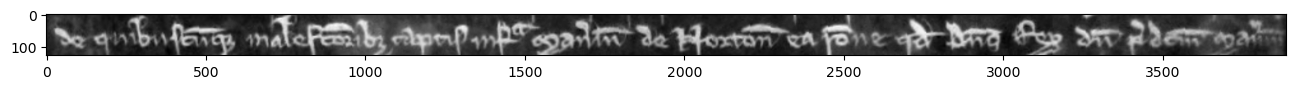

In [10]:
plt.figure(figsize=(16,6))
idx = 10
print(torch.min(val_dataset[idx]["image"]), torch.max(val_dataset[idx]["image"]))
plt.imshow(val_dataset[idx]["image"][0], cmap="gray")

In [11]:
train_loader = utils.data.DataLoader(train_dataset, num_workers=4)
valid_loader = utils.data.DataLoader(val_dataset, num_workers=4)

In [12]:
trainer = L.Trainer(accumulate_grad_batches=1, max_epochs=250)
trainer.fit(transcriber, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params
-------------------------------------------------
0 | cer_calc       | CharErrorRate | 0     
1 | wer_calc       | WordErrorRate | 0     
2 | train_cer_calc | CharErrorRate | 0     
3 | train_wer_calc | WordErrorRate | 0     
4 | net            | MyNN          | 7.9 M 
-------------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M   

Sanity Checking: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 0 -0.7279 -19.0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 0 -inf -inf


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 1 -inf -inf


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 2 -3.3165 -2.1978


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 3 -1.5438 -0.4547


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 4 -0.8611 -0.0615


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 5 -0.5498 -0.1056


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 6 -0.172 -0.0638


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 7 -0.1195 -0.0324


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 8 0.0432 -0.0279


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 9 0.066 -0.0065


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 10 0.1518 0.0375


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 11 0.215 0.0369


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 12 0.2172 0.072


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 13 0.2543 0.0487


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 14 0.3341 0.0763


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 15 0.3556 0.0925


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 16 0.4119 0.0921


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 17 0.472 0.1205


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 18 0.4645 0.1309


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 19 0.559 0.1913


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 20 0.5559 0.1887


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 21 0.5678 0.1899


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 22 0.5798 0.182


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 23 0.5926 0.2115


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 24 0.6252 0.2102


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 25 0.6183 0.2193


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 26 0.6443 0.2454


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 27 0.6699 0.2593


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 28 0.6522 0.2393


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 29 0.6569 0.2475


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 30 0.6809 0.2744


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 31 0.6656 0.2765


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 32 0.6949 0.3022


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 33 0.6929 0.2859


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 34 0.6895 0.306


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 35 0.6986 0.2996


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 36 0.7113 0.2773


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 37 0.7158 0.3066


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 38 0.7257 0.3277


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 39 0.7214 0.3084


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 40 0.7362 0.3342


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 41 0.7297 0.348


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 42 0.736 0.3247


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 43 0.7517 0.3624


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 44 0.7467 0.3665


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 45 0.7415 0.3554


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 46 0.7495 0.3441


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 47 0.737 0.3346


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 48 0.7626 0.3922


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 49 0.7324 0.3333


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 50 0.7488 0.3885


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 51 0.7565 0.3903


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 52 0.7659 0.3871


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 53 0.735 0.3514


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 54 0.7462 0.3564


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 55 0.7677 0.4064


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 56 0.7656 0.3983


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 57 0.7717 0.3931


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 58 0.7673 0.412


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 59 0.7634 0.4226


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 60 0.7576 0.3771


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 61 0.7591 0.3918


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 62 0.76 0.3878


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 63 0.7631 0.3966


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 64 0.7734 0.3995


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 65 0.7894 0.4363


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 66 0.7846 0.4244


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 67 0.7395 0.3533


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 68 0.7762 0.3938


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 69 0.7792 0.4153


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 70 0.7801 0.4211


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 71 0.7925 0.4488


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 72 0.7709 0.4134


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 73 0.7737 0.4056


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 74 0.7628 0.4129


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 75 0.7826 0.401


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 76 0.7618 0.3514


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 77 0.7866 0.4356


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 78 0.7907 0.416


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 79 0.7877 0.41


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 80 0.7693 0.389


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 81 0.77 0.4042


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 82 0.7913 0.4254


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 83 0.7968 0.4412


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 84 0.7824 0.421


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 85 0.8 0.4642


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 86 0.8038 0.4557


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 87 0.8073 0.4451


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 88 0.7961 0.4473


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 89 0.8134 0.472


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 90 0.7973 0.4495


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 91 0.7885 0.4235


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 92 0.8015 0.4481


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 93 0.793 0.448


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 94 0.8057 0.4627


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 95 0.8021 0.4387


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 96 0.7924 0.4442


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 97 0.8065 0.4555


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 98 0.811 0.4666


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 99 0.8094 0.4722


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 100 0.8097 0.4764


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 101 0.8054 0.4647


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 102 0.7909 0.4354


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 103 0.8025 0.4462


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 104 0.8058 0.4541


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 105 0.8024 0.4509


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 106 0.8079 0.4473


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 107 0.8097 0.4642


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 108 0.7853 0.4055


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 109 0.8034 0.4553


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 110 0.8086 0.4672


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 111 0.8088 0.4642


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 112 0.8088 0.4506


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 113 0.7753 0.4071


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 114 0.802 0.4552


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 115 0.8012 0.4504


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 116 0.8126 0.4667


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 117 0.8144 0.4642


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 118 0.8207 0.4788


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 119 0.8275 0.4976


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 120 0.8121 0.4639


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 121 0.827 0.4945


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 122 0.8171 0.4757


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 123 0.8169 0.4873


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 124 0.8289 0.5054


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 125 0.8216 0.4928


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 126 0.8172 0.478


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 127 0.8181 0.4854


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 128 0.8204 0.4867


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 129 0.8206 0.4952


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 130 0.826 0.5061


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 131 0.8331 0.5096


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 132 0.8304 0.4939


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 133 0.8125 0.4681


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 134 0.8276 0.5036


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 135 0.8138 0.4847


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 136 0.824 0.4824


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 137 0.8183 0.4777


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 138 0.8377 0.5139


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 139 0.8333 0.5211


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 140 0.8244 0.5091


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 141 0.8334 0.5175


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 142 0.8168 0.4837


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 143 0.8098 0.4867


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 144 0.8293 0.5108


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 145 0.8241 0.4988


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 146 0.8321 0.5144


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 147 0.8174 0.4787


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 148 0.8281 0.518


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 149 0.8305 0.5072


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 150 0.8407 0.5312


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 151 0.8398 0.5442


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 152 0.8437 0.5403


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 153 0.8417 0.5271


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 154 0.845 0.5393


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 155 0.8372 0.5187


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 156 0.8348 0.5012


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 157 0.8311 0.5055


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 158 0.8348 0.5188


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 159 0.845 0.5396


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 160 0.8464 0.526


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 161 0.8376 0.5252


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 162 0.8445 0.5324


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 163 0.8477 0.5384


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 164 0.8362 0.5315


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 165 0.8372 0.5424


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 166 0.837 0.5218


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 167 0.8398 0.5293


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 168 0.8462 0.5393


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 169 0.8426 0.5411


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 170 0.8378 0.5286


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 171 0.8475 0.5522


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 172 0.8421 0.54


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 173 0.8448 0.535


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 174 0.8396 0.5253


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 175 0.8454 0.5378


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 176 0.8458 0.5396


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 177 0.8501 0.5457


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 178 0.8455 0.5325


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 179 0.8478 0.5451


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 180 0.8473 0.5457


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 181 0.848 0.548


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 182 0.8482 0.542


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 183 0.8509 0.559


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 184 0.8509 0.5457


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 185 0.8484 0.5341


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 186 0.8459 0.5412


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 187 0.8501 0.5471


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 188 0.8507 0.545


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 189 0.8494 0.5632


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 190 0.8445 0.537


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 191 0.8452 0.545


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 192 0.8498 0.546


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 193 0.8532 0.553


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 194 0.8555 0.5598


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 195 0.8564 0.5723


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 196 0.8441 0.5281


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 197 0.851 0.5585


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 198 0.8489 0.5505


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 199 0.8525 0.5457


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 200 0.8525 0.545


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 201 0.8546 0.5652


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 202 0.8486 0.5349


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 203 0.8563 0.5865


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 204 0.8398 0.5318


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 205 0.8453 0.5332


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 206 0.8557 0.5544


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 207 0.8554 0.5636


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 208 0.8578 0.5582


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 209 0.8534 0.5535


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 210 0.8523 0.5499


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 211 0.8451 0.5314


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 212 0.8494 0.5428


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 213 0.8484 0.5415


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 214 0.8495 0.5544


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 215 0.8517 0.5592


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 216 0.856 0.573


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 217 0.8513 0.5587


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 218 0.842 0.5331


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 219 0.8505 0.5516


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 220 0.8508 0.5569


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 221 0.8555 0.5687


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 222 0.8424 0.5446


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 223 0.853 0.5618


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 224 0.8548 0.5651


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 225 0.8495 0.5427


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 226 0.8379 0.5276


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 227 0.8452 0.5455


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 228 0.8453 0.5451


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 229 0.848 0.5474


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 230 0.844 0.5386


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 231 0.8522 0.5541


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 232 0.8518 0.5457


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 233 0.8532 0.5475


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 234 0.8401 0.5265


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 235 0.8505 0.5414


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 236 0.8511 0.5562


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 237 0.8509 0.5458


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 238 0.8549 0.5578


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 239 0.8455 0.5296


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 240 0.8485 0.5489


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 241 0.8452 0.5342


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 242 0.8459 0.5364


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 243 0.8478 0.5395


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 244 0.8538 0.5585


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 245 0.8478 0.5467


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 246 0.8587 0.565


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 247 0.8538 0.5668


Validation: 0it [00:00, ?it/s]

Epoch, char acc, word acc: 248 0.8553 0.5578


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch, char acc, word acc: 249 0.8384 0.5347


In [13]:
#torch.save(net.state_dict(), "my_custom_best.pt") %94% char, 82% word
#torch.save(net.state_dict(), "my_aguillar_repro.pt") #91% char, 69% word
#torch.save(net.state_dict(), "my_all_custom_best.pt") #88% char, 66% word
#torch.save(net.state_dict(), "aguillar_with_augment.pt") #87% char, 60% word 
#torch.save(net.state_dict(), "lower_case.pt") #89% char, 65% word
#small alph big lstm:: 89% char, 65% word
#torch.save(net.state_dict(), "merge_j_i.pt") #88% char, 64% word. Also getting rid of almost all punctuation